In [12]:
import csiroct_imbl_asci as cia
import os
import os.path
import logging
import h5py
import matplotlib.pyplot as plt

run_on_asci = True

dir_experiment_input_asci = '/user/home/imbl/14774/input/Lung_HRCT/19-2-R2202-Lung'
dir_experiment_output_asci = '/user/home/imbl/14774/output/19-2-R2202-Lung'

dir_experiment_input_local = '/mnt/csiro/civ/scratch/lung/HRCT/19-2-R2173-Lung'
dir_experiment_output_local = '/mnt/Data/19-2-R2173-Lung'

if run_on_asci:
    dir_experiment_input = dir_experiment_input_asci
    dir_experiment_output = dir_experiment_output_asci
    
    cmdXLICTPreProcSino = '/opt/x-tract/bin/XLIPreProcSinoMPI'
    cmdXLICTWorkflowMPI = '/opt/x-tract/bin/XLICTWorkflowMPI'
    cmdXLICTReconMPI = '/opt/x-tract/bin/XLICTReconMPI'
    cmdXLICOR = None    
else:
    dir_experiment_input = dir_experiment_input_local
    dir_experiment_output = dir_experiment_output_local
    
    cmdXLICTPreProcSino = '/home/tho78s/development/X-TRACT-trunk/build/linux/XLIPreProcSinoMPI.exe'
    cmdXLICTWorkflowMPI = '/home/tho78s/development/X-TRACT-trunk/build/linux/XLICTWorkflowMPI.exe'
    cmdXLICTReconMPI = '/home/tho78s/development/X-TRACT-trunk/build/linux/XLICTReconMPI.exe'
    cmdXLICOR = '/home/tho78s/development/X-TRACT-trunk/build/linux/XLICOR.exe'    
    
# Create the output folder if it doesn't already exist
if not os.path.exists( dir_experiment_output ):
    os.mkdir( dir_experiment_output )
    
# construct filenames
epics_flat_h5 = os.path.join( dir_experiment_input, 'BG_BEFORE.hdf' )
epics_dark_h5 = os.path.join( dir_experiment_input, 'DF_BEFORE.hdf' )
epics_sample_h5 = os.path.join( dir_experiment_input, 'SAMPLE.hdf' )

xtract_input_convert_h5 = os.path.join( dir_experiment_output, 'test_x-tract_convert.h5' )
xtract_output_ctworkflow_h5 = os.path.join( dir_experiment_output, 'test_x-tract_ctworkflow.h5' ) 
xtract_output_preproc_h5 = os.path.join( dir_experiment_output, 'test_x-tract_preproc.h5' )


In [5]:
# Convert input EPICS HDF5 files (if required)

# Convert to X-TRACT compatible HDF5 using the same EPICS
# test file for flats, darks and samples
num_proj = cia.convert_epics_to_xtract_hdf5(
        epics_flat_h5,
        epics_dark_h5,
        epics_sample_h5,
        xtract_input_convert_h5 )

print( 'Number of copied projections =', num_proj )

Number of copied projections = 2730


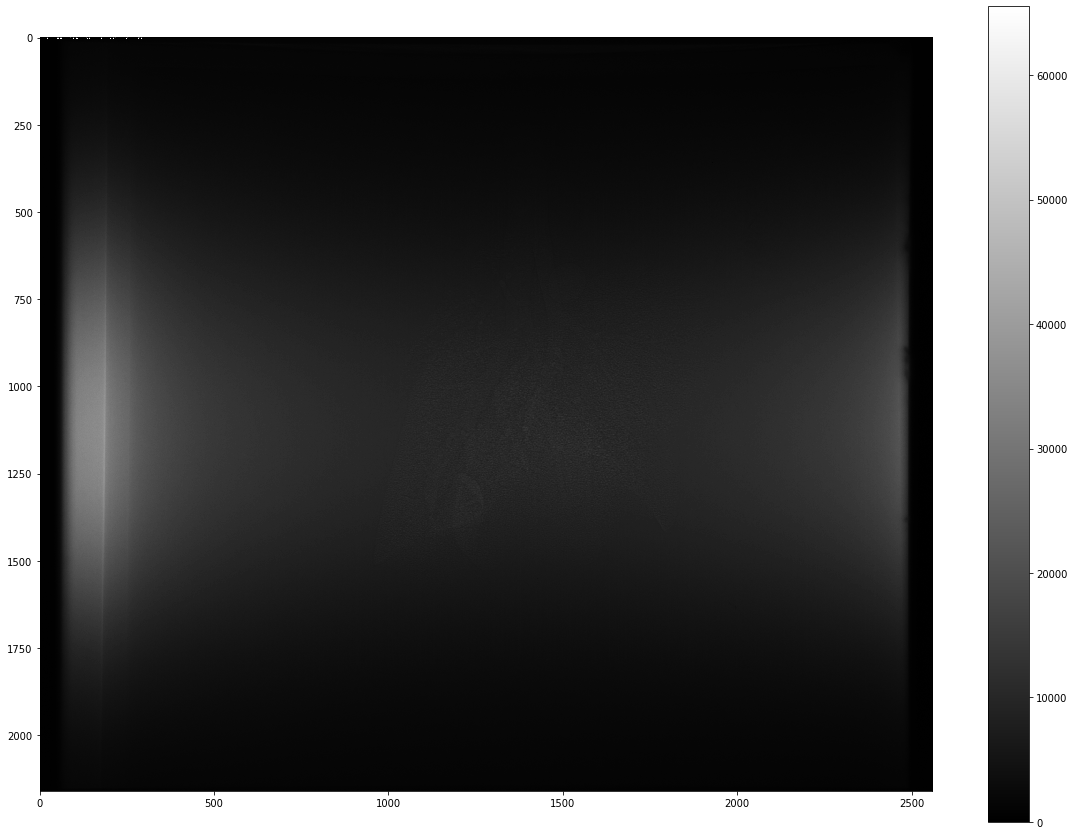

In [6]:
# Display the first converted projection
with h5py.File(xtract_input_convert_h5, 'r') as f:    
    fig, ax = plt.subplots(figsize=(20, 15))
    fig.colorbar( ax.imshow(f['exchange/data'][0] , cmap='gray'), ax=ax)  
    plt.show()

In [7]:
# Create a dictionary of general X-TRACT application parameters that
# are shared between the PreProc, Workflow and Recon applications.
# For a full description of possible parameters, see the
# XLICTWorkflow Parameter Description.xlsx spreadsheet in the docs folder.

dictParamsCore = { 
    'energy': '30',                              # keV
    'pixel_size' : '19.25',                      # um
    'dark_correction' : '1',                     # on
    'flat_correction' : '1',                     # on
    'flat_method' : '0',                         # average flats
    'phase_extraction_pbi': '1',                 # on
    'phase_extraction_pbi_method' : '0',         # TIE-Hom
    'phase_extraction_pbi_rprime' : '30000',     # um
    'phase_extraction_delta_to_beta' : '1000'    # Delta-to-Beta ratio
}

print( dictParamsCore )

{'energy': '30', 'pixel_size': '19.25', 'dark_correction': '1', 'flat_correction': '1', 'flat_method': '0', 'phase_extraction_pbi': '1', 'phase_extraction_pbi_method': '0', 'phase_extraction_pbi_rprime': '30000', 'phase_extraction_delta_to_beta': '1000'}


In [8]:
# Create a dictionary for XLIPreProc specific parameters, 
# added to from dictParamsCore
dictPreProc = dictParamsCore.copy()
dictPreProc['hdf5_input_file'] = xtract_input_convert_h5
dictPreProc['hdf5_output_file'] = xtract_output_preproc_h5
dictPreProc['output_sinograms'] = '1'                            # Output sinograms
dictPreProc['proj'] = 'dummy'                                    # This is set to work-around a bug, can be anything

print( dictPreProc )

{'energy': '30', 'pixel_size': '19.25', 'dark_correction': '1', 'flat_correction': '1', 'flat_method': '0', 'phase_extraction_pbi': '1', 'phase_extraction_pbi_method': '0', 'phase_extraction_pbi_rprime': '30000', 'phase_extraction_delta_to_beta': '1000', 'hdf5_input_file': '/user/home/imbl/14774/output/19-2-R2202-Lung/test_x-tract_convert.h5', 'hdf5_output_file': '/user/home/imbl/14774/output/19-2-R2202-Lung/test_x-tract_preproc.h5', 'output_sinograms': '1', 'proj': 'dummy'}


In [ ]:
# Run XLICTPreProc

cia.run_XLICTPreProc(dictPreProc, cmdXLICTPreProcSino)

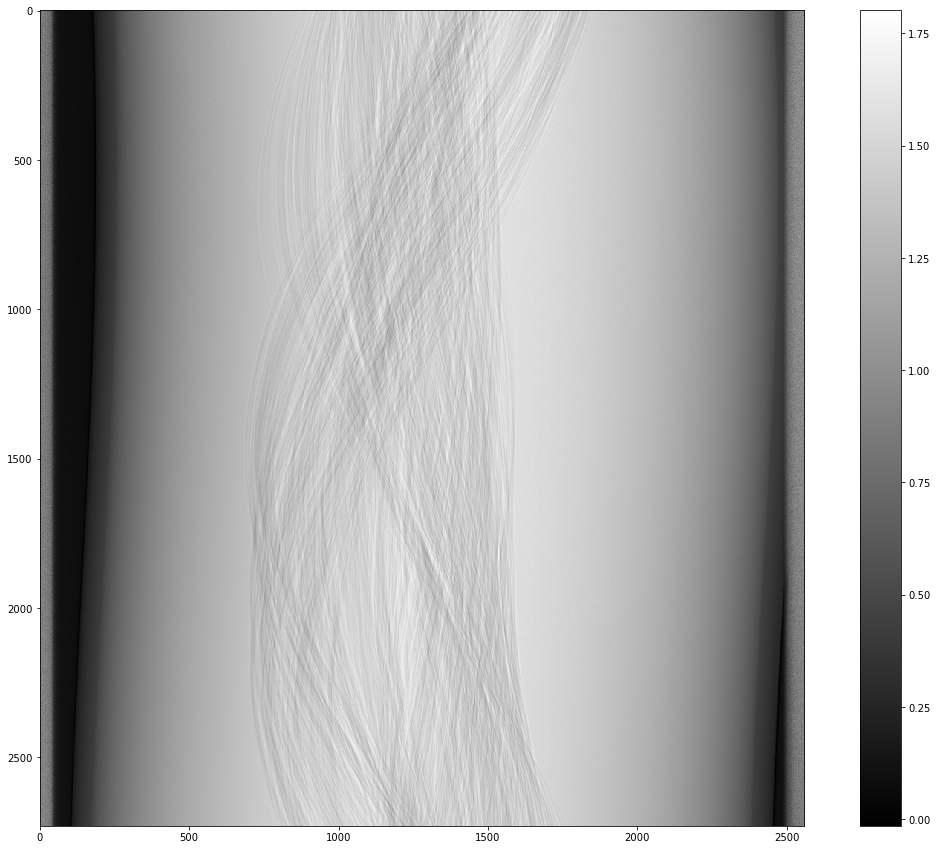

In [7]:
# Display the middle sinogram
with h5py.File(xtract_output_preproc_h5, 'r') as f:
    dset = f['exchange/data_sino']
    fig, ax = plt.subplots(figsize=(20, 15))
    fig.colorbar( ax.imshow(dset[dset.shape[0]/2] , cmap='gray'), ax=ax)  
    plt.show()

In [9]:
# Determine the number of projections in the input HDF5 file
num_proj = cia.get_num_projections(xtract_input_convert_h5)
                                 
# Use the number of projections to calculate the angle step
angle_step = 180.0 / num_proj
                                 
print( 'num_proj = {0}, angle_step = {1}'.format( num_proj, angle_step) )
                             
# Create a dictionary for XLICTWorkflow specific parameters
dictWorkflow = dictParamsCore.copy()
dictWorkflow['hdf5_input_file'] = xtract_input_convert_h5
dictWorkflow['hdf5_output_file'] = xtract_output_ctworkflow_h5
dictWorkflow['cor_method'] = '2'                                    # error method
dictWorkflow['recon_method'] = '0'                                  # FBP (GPU) 
dictWorkflow['recon_out_mu'] = '1'                                  # recon output as Mu values
dictWorkflow['zslice_range_method'] = '0'                           # reconstruct all slices
dictWorkflow['angle_step'] = str(angle_step)                        # angle step (degrees)
#dictPreProc['output_sinograms'] = '1'                               # Output sinograms

print(dictWorkflow)

num_proj = 2730, angle_step = 0.06593406593406594
{'energy': '30', 'pixel_size': '19.25', 'dark_correction': '1', 'flat_correction': '1', 'flat_method': '0', 'phase_extraction_pbi': '1', 'phase_extraction_pbi_method': '0', 'phase_extraction_pbi_rprime': '30000', 'phase_extraction_delta_to_beta': '1000', 'hdf5_input_file': '/user/home/imbl/14774/output/19-2-R2202-Lung/test_x-tract_convert.h5', 'hdf5_output_file': '/user/home/imbl/14774/output/19-2-R2202-Lung/test_x-tract_ctworkflow.h5', 'cor_method': '2', 'recon_method': '0', 'recon_out_mu': '1', 'zslice_range_method': '0', 'angle_step': '0.06593406593406594'}


In [13]:
# Run XLICTWorkflow
cia.run_XLICTWorkflow(dictWorkflow, cmdXLICTWorkflowMPI)

Rank: 0 Host: asci
ARGS/OPT: First Args:
1: /opt/x-tract/bin/XLICTWorkflowMPI

Options:

-af, --angle_file:
Not set

-am, --angle_method:
Not set

-as, --angle_step:
0.06593406593406594

-cor, --cor_method:
2

-corm, --cor_manual:
Not set

-cors, --cor_sinogram_index:
Not set

-dc, --dark_correction:
1

-drg, --darks:
Not set

-e, --energy:
30

-fa, --average_filter:
Not set

-fb, --flat_size_batch:
Not set

-fc, --flat_correction:
1

-fd, --flat_subtract_dark:
Not set

-fm, --flat_method:
0

-fn, --flat_size_interval:
Not set

-fr, --recon_filter:
Not set

-fre, --recon_filter_enabled:
Not set

-frg, --flats:
Not set

-frr, --ring_filter_reconslice:
Not set

-frs, --ring_filter_sinogram:
Not set

-fz, --zingers_filter:
Not set

-fzs, --zingers_filter_size:
Not set

-fzt, --zingers_filter_threshold:
Not set

-h5fo, --hdf5_copy_input_files:
Not set

-h5if, --hdf5_input_file:
/user/home/imbl/14774/output/19-2-R2202-Lung/test_x-tract_convert.h5

-h5io, --hdf5_output_to_input:
Not set

-h5

<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 156, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 169, pSlab->Get_nSize() = 13
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 182, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 195, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 208, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 221, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 234, pSlab->Get_nSize() = 13
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
<<IncPro

<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 936, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 949, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 962, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 975, pSlab->Get_nSize() = 13
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 988, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 1001, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 1014, pSlab->Get_nSize() = 13
<<IncP

<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 1703, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 1716, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 1729, pSlab->Get_nSize() = 13
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 1742, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 1755, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 1768, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 1781, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSl

<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 2470, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 2483, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 2496, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 2509, pSlab->Get_nSize() = 13
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 2522, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 2535, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection Slab, pSlab->Get_nSliceOffset() = 2548, pSlab->Get_nSize() = 13
<<IncProgress=13>>
Process: 0, Thread: 0, Get Projection S

Process: 0, Thread: 0, Put Sinogram Slab, SliceOffset = 2040
<<IncProgress=30>>
Process: 0, Thread: 0, Put Sinogram Slab, SliceOffset = 2070
<<IncProgress=30>>
Process: 0, Thread: 0, Put Sinogram Slab, SliceOffset = 2100
<<IncProgress=30>>
Process: 0, Thread: 0, Put Sinogram Slab, SliceOffset = 2130
<<IncProgress=30>>
<< COR= 0>>
>>>>> Progress: SetResultString (0) 0
Process: 0, Thread: 0, xlicalc::CTWorkflowVolumeProcessor::DoCalculateCTReconProcessingResources(), Available memory = 2.09206 GB 
Process: 0, Thread: 0, xlicalcmpi::CTWorkflowVolumeProcessor::DoCalculateCTReconProcessingResources(), nSlabSizeLocal = 21, m_nSlabSize_CTRecon = 21
Process: 0, Thread: 0, xlicalcmpi::CTWorkflowVolumeProcessor::DoCalculateCTReconProcessingResources(), nSlabSizeGlobalMin = 21
Process: 0, Thread: 0, xlicalc::CTReconVolumeProcessor m_nCTReconPartitionBegin_Internal = 0, m_nCTReconPartitionEnd_Internal = 2159
Process: 0, Thread: 0, xlicalc::DoCTReconSlabProcessing(), Slab Size = 21, Max Working Sla

Thread ( 11 ) , Released GPU device = 1
Thread ( 23 ) , Acquired random GPU device = 1
Thread ( 26 ) , Released GPU device = 0
Thread ( 34 ) , Acquired random GPU device = 0
Process: 0, Thread: 26, Reconstructed slice 60
Process: 0, Thread: 11, Reconstructed slice 24
Thread ( 23 ) , Released GPU device = 1
Thread ( 21 ) , Acquired random GPU device = 1
Thread ( 34 ) , Released GPU device = 0
Thread ( 10 ) , Acquired random GPU device = 0
Process: 0, Thread: 34, Reconstructed slice 63
Process: 0, Thread: 23, Reconstructed slice 42
Thread ( 21 ) , Released GPU device = 1
Thread ( 15 ) , Acquired random GPU device = 1
Thread ( 10 ) , Released GPU device = 0
Thread ( 2 ) , Acquired random GPU device = 0
Process: 0, Thread: 10, Reconstructed slice 65
Process: 0, Thread: 21, Reconstructed slice 51
Thread ( 15 ) , Released GPU device = 1
Thread ( 44 ) , Acquired random GPU device = 1
Thread ( 2 ) , Released GPU device = 0
Thread ( 32 ) , Acquired random GPU device = 0
Process: 0, Thread: 2, R

Thread ( 47 ) , Released GPU device = 1
Thread ( 26 ) , Acquired random GPU device = 1
Thread ( 9 ) , Released GPU device = 0
Thread ( 36 ) , Acquired random GPU device = 0
Process: 0, Thread: 47, Reconstructed slice 97
Process: 0, Thread: 9, Reconstructed slice 120
Thread ( 26 ) , Released GPU device = 1
Thread ( 34 ) , Acquired random GPU device = 1
Thread ( 36 ) , Released GPU device = 0
Thread ( 35 ) , Acquired random GPU device = 0
Process: 0, Thread: 36, Reconstructed slice 125
Process: 0, Thread: 26, Reconstructed slice 100
Thread ( 35 ) , Released GPU device = 0
Thread ( 39 ) , Acquired random GPU device = 0
Thread ( 34 ) , Released GPU device = 1
Thread ( 10 ) , Acquired random GPU device = 1
Process: 0, Thread: 35, Reconstructed slice 128
Process: 0, Thread: 34, Reconstructed slice 102
Thread ( 39 ) , Released GPU device = 0
Thread ( 14 ) , Acquired random GPU device = 0
Thread ( 10 ) , Released GPU device = 1
Thread ( 31 ) , Acquired random GPU device = 1
Process: 0, Thread:

Thread ( 43 ) , Released GPU device = 0
Thread ( 33 ) , Acquired random GPU device = 0
Thread ( 26 ) , Released GPU device = 1
Thread ( 34 ) , Acquired random GPU device = 1
Process: 0, Thread: 43, Reconstructed slice 180
Process: 0, Thread: 26, Reconstructed slice 161
Thread ( 33 ) , Released GPU device = 0
Thread ( 25 ) , Acquired random GPU device = 0
Thread ( 34 ) , Released GPU device = 1
Thread ( 10 ) , Acquired random GPU device = 1
Process: 0, Thread: 33, Reconstructed slice 186
Process: 0, Thread: 34, Reconstructed slice 163
Thread ( 25 ) , Released GPU device = 0
Thread ( 28 ) , Acquired random GPU device = 0
Thread ( 10 ) , Released GPU device = 1
Thread ( 14 ) , Acquired random GPU device = 1
Process: 0, Thread: 10, Reconstructed slice 165
Process: 0, Thread: 25, Reconstructed slice 187
Thread ( 28 ) , Released GPU device = 0
Thread ( 19 ) , Acquired random GPU device = 0
Thread ( 14 ) , Released GPU device = 1
Thread ( 41 ) , Acquired random GPU device = 1
Process: 0, Thre

Thread ( 21 ) , Released GPU device = 1
Thread ( 13 ) , Acquired random GPU device = 1
Thread ( 15 ) , Released GPU device = 0
Thread ( 16 ) , Acquired random GPU device = 0
Process: 0, Thread: 21, Reconstructed slice 210
Process: 0, Thread: 15, Reconstructed slice 241
Thread ( 13 ) , Released GPU device = 1
Thread ( 29 ) , Acquired random GPU device = 1
Thread ( 16 ) , Released GPU device = 0
Thread ( 7 ) , Acquired random GPU device = 0
Process: 0, Thread: 16, Reconstructed slice 243
Process: 0, Thread: 13, Reconstructed slice 212
Process: 0, Thread: 0, Put Slice Slab, Slice Offset = 189, size = 21
Thread ( 29 ) , Released GPU device = 1
Thread ( 34 ) , Acquired random GPU device = 1
Thread ( 7 ) , Released GPU device = 0
Thread ( 26 ) , Acquired random GPU device = 0
Process: 0, Thread: 29, Reconstructed slice 217
Process: 0, Thread: 7, Reconstructed slice 244
Thread ( 34 ) , Released GPU device = 1
Thread ( 41 ) , Acquired random GPU device = 1
Thread ( 26 ) , Released GPU device =

Thread ( 15 ) , Released GPU device = 0
Thread ( 21 ) , Acquired random GPU device = 0
Thread ( 1 ) , Released GPU device = 1
Thread ( 41 ) , Acquired random GPU device = 1
Process: 0, Thread: 15, Reconstructed slice 305
Process: 0, Thread: 1, Reconstructed slice 272
Thread ( 41 ) , Released GPU device = 1
Thread ( 7 ) , Acquired random GPU device = 1
Thread ( 21 ) , Released GPU device = 0
Thread ( 29 ) , Acquired random GPU device = 0
Process: 0, Thread: 0, Put Slice Slab, Slice Offset = 252, size = 21
Process: 0, Thread: 21, Reconstructed slice 306
Process: 0, Thread: 41, Reconstructed slice 273
Thread ( 29 ) , Released GPU device = 0
Thread ( 13 ) , Acquired random GPU device = 0
Thread ( 7 ) , Released GPU device = 1
Thread ( 6 ) , Acquired random GPU device = 1
Process: 0, Thread: 29, Reconstructed slice 309
Process: 0, Thread: 7, Reconstructed slice 277
Thread ( 13 ) , Released GPU device = 0
Thread ( 18 ) , Acquired random GPU device = 0
Thread ( 6 ) , Released GPU device = 1
T

Thread ( 24 ) , Released GPU device = 0
Thread ( 7 ) , Acquired random GPU device = 0
Thread ( 10 ) , Released GPU device = 1
Thread ( 8 ) , Acquired random GPU device = 1
Process: 0, Thread: 10, Reconstructed slice 354
Process: 0, Thread: 24, Reconstructed slice 341
Thread ( 7 ) , Released GPU device = 0
Thread ( 6 ) , Acquired random GPU device = 0
Thread ( 8 ) , Released GPU device = 1
Thread ( 4 ) , Acquired random GPU device = 1
Process: 0, Thread: 8, Reconstructed slice 352
Process: 0, Thread: 7, Reconstructed slice 347
Thread ( 6 ) , Released GPU device = 0
Thread ( 9 ) , Acquired random GPU device = 0
Thread ( 4 ) , Released GPU device = 1
Thread ( 34 ) , Acquired random GPU device = 1
Process: 0, Thread: 4, Reconstructed slice 361
Process: 0, Thread: 6, Reconstructed slice 359
Thread ( 34 ) , Released GPU device = 1
Thread ( 43 ) , Acquired random GPU device = 1
Thread ( 9 ) , Released GPU device = 0
Thread ( 5 ) , Acquired random GPU device = 0
Process: 0, Thread: 9, Reconstr

Thread ( 42 ) , Released GPU device = 1
Thread ( 26 ) , Acquired random GPU device = 1
Thread ( 40 ) , Released GPU device = 0
Thread ( 2 ) , Acquired random GPU device = 0
Process: 0, Thread: 40, Reconstructed slice 407
Process: 0, Thread: 42, Reconstructed slice 406
Thread ( 26 ) , Released GPU device = 1
Thread ( 14 ) , Acquired random GPU device = 1
Thread ( 2 ) , Released GPU device = 0
Thread ( 27 ) , Acquired random GPU device = 0
Process: 0, Thread: 26, Reconstructed slice 410
Process: 0, Thread: 2, Reconstructed slice 408
Thread ( 14 ) , Released GPU device = 1
Thread ( 15 ) , Acquired random GPU device = 1
Thread ( 27 ) , Released GPU device = 0
Thread ( 25 ) , Acquired random GPU device = 0
Process: 0, Thread: 14, Reconstructed slice 409
Process: 0, Thread: 27, Reconstructed slice 412
Thread ( 15 ) , Released GPU device = 1
Thread ( 17 ) , Acquired random GPU device = 1
Thread ( 25 ) , Released GPU device = 0
Thread ( 39 ) , Acquired random GPU device = 0
Process: 0, Thread:

Thread ( 15 ) , Released GPU device = 0
Thread ( 16 ) , Released GPU device = 1
Thread ( 22 ) , Acquired random GPU device = 1
Thread ( 17 ) , Acquired random GPU device = 0
Process: 0, Thread: 16, Reconstructed slice 477
Process: 0, Thread: 15, Reconstructed slice 460
Thread ( 22 ) , Released GPU device = 1
Thread ( 30 ) , Acquired random GPU device = 1
Thread ( 17 ) , Released GPU device = 0
Thread ( 29 ) , Acquired random GPU device = 0
Process: 0, Thread: 17, Reconstructed slice 462
Process: 0, Thread: 22, Reconstructed slice 482
Process: 0, Thread: 0, Put Slice Slab, Slice Offset = 441, size = 21
Thread ( 30 ) , Released GPU device = 1
Thread ( 13 ) , Acquired random GPU device = 1
Thread ( 29 ) , Released GPU device = 0
Thread ( 18 ) , Acquired random GPU device = 0
Process: 0, Thread: 30, Reconstructed slice 481
Process: 0, Thread: 29, Reconstructed slice 463
Thread ( 13 ) , Released GPU device = 1
Thread ( 9 ) , Acquired random GPU device = 1
Thread ( 18 ) , Released GPU device

<<IncProgress=21>>
Process: 0, Thread: 0, Put Slice Slab, Slice Offset = 504, size = 21
<<IncProgress=21>>
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 525
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 546
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 567
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 588
Thread ( Thread ( 3 ) , Released GPU device = 1
45 ) , Acquired random GPU device = 1
Thread ( 46 ) , Acquired random GPU device = 0
Thread ( 41 ) , Released GPU device = 0
Process: 0, Thread: 3, Reconstructed slice 529
Process: 0, Thread: 41, Reconstructed slice 532
Thread ( 43 ) , Acquired random GPU device = 1
Thread ( 45 ) , Released GPU device = 1
Thread ( 46 ) , Released GPU device = 0
Thread ( 16 ) , Acquired random GPU device = 0
Process: 0, Thread: 46, Reconstructed slice 525
Process: 0, Thread: 45, Reconstructed slice 528
Thread ( 16 ) , Released GPU device = 0
Thread ( 42 ) , Acquired random GPU device = 0
Thread ( 43 ) , Released

Thread ( 39 ) , Released GPU device = 1
Thread ( 8 ) , Acquired random GPU device = 1
Thread ( 43 ) , Released GPU device = 0
Thread ( 1 ) , Acquired random GPU device = 0
Process: 0, Thread: 39, Reconstructed slice 587
Process: 0, Thread: 43, Reconstructed slice 576
Process: 0, Thread: 0, Put Slice Slab, Slice Offset = 546, size = 21
Thread ( 8 ) , Released GPU device = 1
Thread ( 32 ) , Acquired random GPU device = 1
Thread ( 1 ) , Released GPU device = 0
Thread ( 18 ) , Acquired random GPU device = 0
Process: 0, Thread: 1, Reconstructed slice 578
Process: 0, Thread: 8, Reconstructed slice 593
Thread ( 18 ) , Released GPU device = 0
Thread ( 36 ) , Acquired random GPU device = 0
Thread ( 32 ) , Released GPU device = 1
Thread ( 30 ) , Acquired random GPU device = 1
Process: 0, Thread: 18, Reconstructed slice 580
Process: 0, Thread: 32, Reconstructed slice 595
<<IncProgress=21>>
Thread ( 36 ) , Released GPU device = 0
Thread ( 40 ) , Acquired random GPU device = 0
Thread ( 30 ) , Relea

<<IncProgress=21>>
Thread ( 43 ) , Released GPU device = 1
Thread ( 40 ) , Acquired random GPU device = 1
Thread ( 24 ) , Released GPU device = 0
Thread ( 19 ) , Acquired random GPU device = 0
Process: 0, Thread: 24, Reconstructed slice 650
Process: 0, Thread: 43, Reconstructed slice 634
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 693
Thread ( 19 ) , Released GPU device = 0
Thread ( 22 ) , Acquired random GPU device = 0
Thread ( 40 ) , Released GPU device = 1
Thread ( 32 ) , Acquired random GPU device = 1
Process: 0, Thread: 19, Reconstructed slice 652
Process: 0, Thread: 40, Reconstructed slice 635
Thread ( 22 ) , Released GPU device = 0
Thread ( 37 ) , Acquired random GPU device = 0
Thread ( 32 ) , Released GPU device = 1
Thread ( 18 ) , Acquired random GPU device = 1
Process: 0, Thread: 22, Reconstructed slice 654
Process: 0, Thread: 32, Reconstructed slice 637
Thread ( 37 ) , Released GPU device = 0
Thread ( 46 ) , Acquired random GPU device = 0
Thread ( 18 ) , Release

Thread ( 28 ) , Released GPU device = 1
Thread ( 29 ) , Acquired random GPU device = 1
Thread ( 21 ) , Released GPU device = 0
Thread ( 23 ) , Acquired random GPU device = 0
Process: 0, Thread: 21, Reconstructed slice 698
Process: 0, Thread: 28, Reconstructed slice 706
Thread ( 23 ) , Released GPU device = 0
Thread ( 26 ) , Acquired random GPU device = 0
Thread ( 29 ) , Released GPU device = 1
Thread ( 2 ) , Acquired random GPU device = 1
Process: 0, Thread: 29, Reconstructed slice 707
Process: 0, Thread: 23, Reconstructed slice 699
Thread ( 2 ) , Released GPU device = 1
Thread ( 27 ) , Acquired random GPU device = 1
Thread ( 26 ) , Released GPU device = 0
Thread ( 32 ) , Acquired random GPU device = 0
Process: 0, Thread: 2, Reconstructed slice 708
Process: 0, Thread: 26, Reconstructed slice 701
Thread ( 32 ) , Released GPU device = 0
Thread ( 33 ) , Acquired random GPU device = 0
Thread ( 27 ) , Released GPU device = 1
Thread ( 3 ) , Acquired random GPU device = 1
Process: 0, Thread: 

Thread ( 47 ) , Released GPU device = 1
Thread ( 45 ) , Acquired random GPU device = 1
Thread ( 44 ) , Released GPU device = 0
Thread ( 25 ) , Acquired random GPU device = 0
Process: 0, Thread: 44, Reconstructed slice 752
Process: 0, Thread: 47, Reconstructed slice 765
Thread ( 45 ) , Released GPU device = 1
Thread ( 10 ) , Acquired random GPU device = 1
Thread ( 25 ) , Released GPU device = 0
Thread ( 9 ) , Acquired random GPU device = 0
Process: 0, Thread: 45, Reconstructed slice 766
Process: 0, Thread: 25, Reconstructed slice 754
Thread ( 9 ) , Released GPU device = 0
Thread ( 19 ) , Acquired random GPU device = 0
Thread ( 10 ) , Released GPU device = 1
Thread ( 37 ) , Acquired random GPU device = 1
Process: 0, Thread: 9, Reconstructed slice 768
Process: 0, Thread: 10, Reconstructed slice 760
Thread ( 37 ) , Released GPU device = 1
Thread ( 11 ) , Acquired random GPU device = 1
Thread ( 19 ) , Released GPU device = 0
Thread ( 42 ) , Acquired random GPU device = 0
Process: 0, Thread:

Thread ( 33 ) , Released GPU device = 1
Thread ( 25 ) , Released GPU device = 0
Thread ( 37 ) , Acquired random GPU device = 0
Process: 0, Thread: 25, Reconstructed slice 811
Process: 0, Thread: 33, Reconstructed slice 832
Thread ( 12 ) , Released GPU device = 1
Thread ( 41 ) , Acquired random GPU device = 1
Thread ( 37 ) , Released GPU device = 0
Thread ( 9 ) , Acquired random GPU device = 0
Process: 0, Thread: 37, Reconstructed slice 815
Process: 0, Thread: 12, Reconstructed slice 860
Thread ( 41 ) , Released GPU device = 1
Thread ( 34 ) , Acquired random GPU device = 1
Thread ( 9 ) , Released GPU device = 0
Thread ( 42 ) , Acquired random GPU device = 0
Process: 0, Thread: 41, Reconstructed slice 839
Process: 0, Thread: 9, Reconstructed slice 812
Thread ( 34 ) , Released GPU device = 1
Thread ( 23 ) , Acquired random GPU device = 1
Thread ( 42 ) , Released GPU device = 0
Thread ( 11 ) , Acquired random GPU device = 0
Process: 0, Thread: 42, Reconstructed slice 816
Process: 0, Thread

Thread ( 42 ) , Released GPU device = 1
Thread ( 34 ) , Acquired random GPU device = 1
Thread ( 27 ) , Released GPU device = 0
Thread ( 46 ) , Acquired random GPU device = 0
Process: 0, Thread: 27, Reconstructed slice 861
Process: 0, Thread: 42, Reconstructed slice 896
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 924
Thread ( 34 ) , Released GPU device = 1
Thread ( 39 ) , Acquired random GPU device = 1
Thread ( 46 ) , Released GPU device = 0
Thread ( 41 ) , Acquired random GPU device = 0
Process: 0, Thread: 34, Reconstructed slice 897
Process: 0, Thread: 46, Reconstructed slice 872
Thread ( 39 ) , Released GPU device = 1
Thread ( 14 ) , Acquired random GPU device = 1
Thread ( 41 ) , Released GPU device = 0
Thread ( 29 ) , Acquired random GPU device = 0
Process: 0, Thread: 41, Reconstructed slice 877
Process: 0, Thread: 39, Reconstructed slice 893
Thread ( 29 ) , Released GPU device = 0
Thread ( 43 ) , Acquired random GPU device = 0
Thread ( 14 ) , Released GPU device = 1
Th

Thread ( 21 ) , Released GPU device = 0
Thread ( 11 ) , Acquired random GPU device = 0
Process: 0, Thread: 21, Reconstructed slice 936
<<IncProgress=21>>
Process: 0, Thread: 0, Put Slice Slab, Slice Offset = 903, size = 21
Thread ( 11 ) , Released GPU device = 0
Thread ( 10 ) , Acquired random GPU device = 0
Process: 0, Thread: 11, Reconstructed slice 940
Thread ( 10 ) , Released GPU device = 0
Thread ( 13 ) , Acquired random GPU device = 0
<<IncProgress=21>>
Process: 0, Thread: 10, Reconstructed slice 941
Thread ( 13 ) , Released GPU device = 0
Thread ( 5 ) , Acquired random GPU device = 0
Process: 0, Thread: 13, Reconstructed slice 942
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 945
Thread ( 5 ) , Released GPU device = 0
Process: 0, Thread: 5, Reconstructed slice 943
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 966
Process: 0, Thread: 0, Put Slice Slab, Slice Offset = 924, size = 21
<<IncProgress=21>>
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 9

Thread ( 24 ) , Released GPU device = 1
Thread ( 11 ) , Acquired random GPU device = 1
Thread ( 36 ) , Released GPU device = 0
Thread ( 43 ) , Acquired random GPU device = 0
Process: 0, Thread: 24, Reconstructed slice 1010
Process: 0, Thread: 36, Reconstructed slice 991
Thread ( 11 ) , Released GPU device = 1
Thread ( 40 ) , Acquired random GPU device = 1
Thread ( 43 ) , Released GPU device = 0
Thread ( 44 ) , Acquired random GPU device = 0
<<IncProgress=21>>
Process: 0, Thread: 43, Reconstructed slice 990
Process: 0, Thread: 11, Reconstructed slice 1012
Thread ( 40 ) , Released GPU device = 1
Thread ( 32 ) , Acquired random GPU device = 1
Thread ( 44 ) , Released GPU device = 0
Thread ( 3 ) , Acquired random GPU device = 0
Process: 0, Thread: 40, Reconstructed slice 1014
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 1050
Process: 0, Thread: 44, Reconstructed slice 993
Thread ( 32 ) , Released GPU device = 1
Thread ( 22 ) , Acquired random GPU device = 1
Thread ( 3 ) , Relea

Thread ( 17 ) , Released GPU device = 1
Thread ( 16 ) , Acquired random GPU device = 1
Thread ( 40 ) , Released GPU device = 0
Thread ( 32 ) , Acquired random GPU device = 0
Process: 0, Thread: 40, Reconstructed slice 1048
Process: 0, Thread: 17, Reconstructed slice 1064
Thread ( 16 ) , Released GPU device = 1
Thread ( 46 ) , Acquired random GPU device = 1
Thread ( 32 ) , Released GPU device = 0
Thread ( 18 ) , Acquired random GPU device = 0
Process: 0, Thread: 32, Reconstructed slice 1051
Process: 0, Thread: 16, Reconstructed slice 1068
Thread ( 46 ) , Released GPU device = 1
Thread ( 25 ) , Acquired random GPU device = 1
Thread ( 18 ) , Released GPU device = 0
Thread ( 22 ) , Acquired random GPU device = 0
Process: 0, Thread: 18, Reconstructed slice 1052
Process: 0, Thread: 46, Reconstructed slice 1069
Thread ( 25 ) , Released GPU device = 1
Thread ( 26 ) , Acquired random GPU device = 1
Thread ( 22 ) , Released GPU device = 0
Thread ( 28 ) , Acquired random GPU device = 0
Process: 0

Thread ( 8 ) , Released GPU device = 1
Thread ( 20 ) , Acquired random GPU device = 1
Thread ( 25 ) , Released GPU device = 0
Thread ( 28 ) , Acquired random GPU device = 0
Process: 0, Thread: 8, Reconstructed slice 1115
Process: 0, Thread: 25, Reconstructed slice 1109
Thread ( 20 ) , Released GPU device = 1
Thread ( 24 ) , Acquired random GPU device = 1
Thread ( 28 ) , Released GPU device = 0
Thread ( 35 ) , Acquired random GPU device = 0
Process: 0, Thread: 20, Reconstructed slice 1122
Process: 0, Thread: 28, Reconstructed slice 1110
Thread ( 35 ) , Released GPU device = 0
Thread ( 41 ) , Acquired random GPU device = 0
Thread ( 24 ) , Released GPU device = 1
Thread ( 7 ) , Acquired random GPU device = 1
Process: 0, Thread: 24, Reconstructed slice 1124
Process: 0, Thread: 35, Reconstructed slice 1114
Thread ( 7 ) , Released GPU device = 1
Thread ( 44 ) , Acquired random GPU device = 1
Thread ( 41 ) , Released GPU device = 0
Thread ( 30 ) , Acquired random GPU device = 0
Process: 0, Th

Thread ( 2 ) , Released GPU device = 1
Thread ( 33 ) , Acquired random GPU device = 1
Thread ( 25 ) , Released GPU device = 0
Thread ( 35 ) , Acquired random GPU device = 0
Process: 0, Thread: 2, Reconstructed slice 1162
Process: 0, Thread: 25, Reconstructed slice 1174
Thread ( 33 ) , Released GPU device = 1
Thread ( 8 ) , Acquired random GPU device = 1
Thread ( 35 ) , Released GPU device = 0
Thread ( 1 ) , Acquired random GPU device = 0
Process: 0, Thread: 35, Reconstructed slice 1177
Process: 0, Thread: 33, Reconstructed slice 1172
Thread ( 8 ) , Released GPU device = 1
Thread ( 24 ) , Acquired random GPU device = 1
Thread ( 1 ) , Released GPU device = 0
Thread ( 46 ) , Acquired random GPU device = 0
Process: 0, Thread: 1, Reconstructed slice 1182
Process: 0, Thread: 8, Reconstructed slice 1175
Thread ( 24 ) , Released GPU device = 1
Thread ( 21 ) , Acquired random GPU device = 1
Thread ( 46 ) , Released GPU device = 0
Thread ( 19 ) , Acquired random GPU device = 0
Process: 0, Thread

Thread ( 40 ) , Released GPU device = 1
Thread ( 30 ) , Acquired random GPU device = 1
Thread ( 35 ) , Released GPU device = 0
Thread ( 46 ) , Acquired random GPU device = 0
Process: 0, Thread: 35, Reconstructed slice 1221
Process: 0, Thread: 40, Reconstructed slice 1242
<<IncProgress=21>>
Thread ( 30 ) , Released GPU device = 1
Thread ( 47 ) , Acquired random GPU device = 1
Thread ( 46 ) , Released GPU device = 0
Thread ( 24 ) , Acquired random GPU device = 0
Process: 0, Thread: 46, Reconstructed slice 1225
Process: 0, Thread: 30, Reconstructed slice 1241
Thread ( 47 ) , Released GPU device = 1
Thread ( 29 ) , Acquired random GPU device = 1
Thread ( 24 ) , Released GPU device = 0
Thread ( 19 ) , Acquired random GPU device = 0
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 1260
Process: 0, Thread: 24, Reconstructed slice 1226
Process: 0, Thread: 47, Reconstructed slice 1246
Thread ( 19 ) , Released GPU device = 0
Thread ( 45 ) , Acquired random GPU device = 0
Thread ( 29 ) , 

Thread ( 23 ) , Released GPU device = 0
Thread ( 12 ) , Acquired random GPU device = 0
Thread ( 18 ) , Released GPU device = 1
Thread ( 14 ) , Acquired random GPU device = 1
Process: 0, Thread: 23, Reconstructed slice 1278
Process: 0, Thread: 18, Reconstructed slice 1265
Thread ( 14 ) , Released GPU device = 1
Thread ( 24 ) , Acquired random GPU device = 1
Thread ( 12 ) , Released GPU device = 0
Thread ( 16 ) , Acquired random GPU device = 0
Process: 0, Thread: 12, Reconstructed slice 1286
Process: 0, Thread: 14, Reconstructed slice 1301
Thread ( 24 ) , Released GPU device = 1
Thread ( 20 ) , Acquired random GPU device = 1
Thread ( 16 ) , Released GPU device = 0
Thread ( 28 ) , Acquired random GPU device = 0
Process: 0, Thread: 24, Reconstructed slice 1302
Process: 0, Thread: 16, Reconstructed slice 1282
Thread ( 20 ) , Released GPU device = 1
Thread ( 9 ) , Acquired random GPU device = 1
Thread ( 28 ) , Released GPU device = 0
Thread ( 34 ) , Acquired random GPU device = 0
Process: 0,

Thread ( 47 ) , Released GPU device = 0
Thread ( 35 ) , Acquired random GPU device = 0
Thread ( 4 ) , Released GPU device = 1
Thread ( 6 ) , Acquired random GPU device = 1
Process: 0, Thread: 47, Reconstructed slice 1344
Process: 0, Thread: 4, Reconstructed slice 1355
Thread ( 6 ) , Released GPU device = 1
Thread ( 37 ) , Acquired random GPU device = 1
Thread ( 35 ) , Released GPU device = 0
Thread ( 34 ) , Acquired random GPU device = 0
Process: 0, Thread: 6, Reconstructed slice 1358
Process: 0, Thread: 35, Reconstructed slice 1347
Thread ( 37 ) , Released GPU device = 1
Thread ( 34 ) , Released GPU device = 0
Thread ( 8 ) , Acquired random GPU device = 0
Process: 0, Thread: 37, Reconstructed slice 1361
Process: 0, Thread: 34, Reconstructed slice 1349
Thread ( 8 ) , Released GPU device = 0
Thread ( 2 ) , Acquired random GPU device = 0
Process: 0, Thread: 8, Reconstructed slice 1354
Thread ( 2 ) , Released GPU device = 0
Thread ( 27 ) , Acquired random GPU device = 0
Process: 0, Thread

Thread ( 11 ) , Released GPU device = 0
Thread ( 20 ) , Acquired random GPU device = 0
Thread ( 30 ) , Released GPU device = 1
Thread ( 28 ) , Acquired random GPU device = 1
Process: 0, Thread: 11, Reconstructed slice 1425
Process: 0, Thread: 30, Reconstructed slice 1404
Thread ( 28 ) , Released GPU device = 1
Thread ( 29 ) , Acquired random GPU device = 1
Thread ( 20 ) , Released GPU device = 0
Thread ( 1 ) , Acquired random GPU device = 0
Process: 0, Thread: 20, Reconstructed slice 1426
Process: 0, Thread: 28, Reconstructed slice 1410
<<IncProgress=21>>
Thread ( 1 ) , Released GPU device = 0
Thread ( 18 ) , Acquired random GPU device = 0
Thread ( 29 ) , Released GPU device = 1
Thread ( 23 ) , Acquired random GPU device = 1
Process: 0, Thread: 1, Reconstructed slice 1427
Process: 0, Thread: 29, Reconstructed slice 1398
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 1449
Thread ( 23 ) , Released GPU device = 1
Thread ( 12 ) , Acquired random GPU device = 1
Thread ( 18 ) , Rel

Thread ( 18 ) , Released GPU device = 1
Thread ( 11 ) , Acquired random GPU device = 1
Thread ( 40 ) , Released GPU device = 0
Thread ( 42 ) , Acquired random GPU device = 0
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 1512
Process: 0, Thread: 40, Reconstructed slice 1478
Process: 0, Thread: 18, Reconstructed slice 1453
Thread ( 11 ) , Released GPU device = 1
Thread ( 30 ) , Acquired random GPU device = 1
Thread ( 42 ) , Released GPU device = 0
Thread ( 45 ) , Acquired random GPU device = 0
Process: 0, Thread: 42, Reconstructed slice 1482
Process: 0, Thread: 11, Reconstructed slice 1455
Thread ( 30 ) , Released GPU device = 1
Thread ( 34 ) , Acquired random GPU device = 1
Thread ( 45 ) , Released GPU device = 0
Thread ( 25 ) , Acquired random GPU device = 0
Process: 0, Thread: 45, Reconstructed slice 1480
Process: 0, Thread: 30, Reconstructed slice 1456
Thread ( 34 ) , Released GPU device = 1
Thread ( 9 ) , Acquired random GPU device = 1
Thread ( 25 ) , Released GPU device 

Thread ( 7 ) , Released GPU device = 0
Thread ( 18 ) , Acquired random GPU device = 0
Thread ( 2 ) , Released GPU device = 1
Thread ( 12 ) , Acquired random GPU device = 1
Process: 0, Thread: 2, Reconstructed slice 1509
Process: 0, Thread: 7, Reconstructed slice 1537
Thread ( 12 ) , Released GPU device = 1
Thread ( 8 ) , Acquired random GPU device = 1
Thread ( 18 ) , Released GPU device = 0
Thread ( 37 ) , Acquired random GPU device = 0
Process: 0, Thread: 12, Reconstructed slice 1507
Process: 0, Thread: 18, Reconstructed slice 1538
Thread ( 8 ) , Released GPU device = 1
Thread ( 1 ) , Acquired random GPU device = 1
Thread ( 37 ) , Released GPU device = 0
Thread ( 11 ) , Acquired random GPU device = 0
Process: 0, Thread: 8, Reconstructed slice 1511
Process: 0, Thread: 37, Reconstructed slice 1539
Thread ( 11 ) , Released GPU device = 0
Thread ( 45 ) , Acquired random GPU device = 0
Thread ( 1 ) , Released GPU device = 1
Thread ( 44 ) , Acquired random GPU device = 1
Process: 0, Thread:

Thread ( 14 ) , Released GPU device = 1
Thread ( 8 ) , Acquired random GPU device = 1
Thread ( 32 ) , Released GPU device = 0
Thread ( 40 ) , Acquired random GPU device = 0
Process: 0, Thread: 14, Reconstructed slice 1617
Process: 0, Thread: 32, Reconstructed slice 1581
Thread ( 8 ) , Released GPU device = 1
Thread ( 5 ) , Acquired random GPU device = 1
Thread ( 40 ) , Released GPU device = 0
Thread ( 25 ) , Acquired random GPU device = 0
Process: 0, Thread: 40, Reconstructed slice 1575
Process: 0, Thread: 8, Reconstructed slice 1587
Thread ( 5 ) , Released GPU device = 1
Thread ( 11 ) , Acquired random GPU device = 1
Thread ( 25 ) , Released GPU device = 0
Thread ( 13 ) , Acquired random GPU device = 0
Process: 0, Thread: 25, Reconstructed slice 1589
Process: 0, Thread: 5, Reconstructed slice 1597
Thread ( 11 ) , Released GPU device = 1
Thread ( 28 ) , Acquired random GPU device = 1
Thread ( 13 ) , Released GPU device = 0
Thread ( 20 ) , Acquired random GPU device = 0
Process: 0, Thre

Thread ( 38 ) , Released GPU device = 1
Thread ( 43 ) , Acquired random GPU device = 1
Thread ( 13 ) , Released GPU device = 0
Thread ( 28 ) , Acquired random GPU device = 0
Process: 0, Thread: 38, Reconstructed slice 1651
Process: 0, Thread: 13, Reconstructed slice 1635
Thread ( 43 ) , Released GPU device = 1
Thread ( 10 ) , Acquired random GPU device = 1
Thread ( 12Thread ( 28 ) , Released GPU device = 0 ) 
, Acquired random GPU device = 0
Process: 0, Thread: 28, Reconstructed slice 1637
Process: 0, Thread: 43, Reconstructed slice 1656
Thread ( 10 ) , Released GPU device = 1
Thread ( 41 ) , Acquired random GPU device = 1
Thread ( 12 ) , Released GPU device = 0
Thread ( 6 ) , Acquired random GPU device = 0
Process: 0, Thread: 12, Reconstructed slice 1684
Process: 0, Thread: 10, Reconstructed slice 1655
Thread ( 41 ) , Released GPU device = 1
Thread ( 35 ) , Acquired random GPU device = 1
Thread ( 6 ) , Released GPU device = 0
Thread ( 21 ) , Acquired random GPU device = 0
Process: 0, 

Thread ( 20 ) , Released GPU device = 0
Thread ( 27 ) , Acquired random GPU device = 0
Process: 0, Thread: 20, Reconstructed slice 1638
Thread ( 27 ) , Released GPU device = 0
Thread ( 11 ) , Acquired random GPU device = 0
Process: 0, Thread: 27, Reconstructed slice 1685
Process: 0, Thread: 0, Put Slice Slab, Slice Offset = 1638, size = 21
Thread ( 11 ) , Released GPU device = 0
Thread ( 9 ) , Acquired random GPU device = 0
Process: 0, Thread: 11, Reconstructed slice 1688
Thread ( 9 ) , Released GPU device = 0
Thread ( 38 ) , Acquired random GPU device = 0
Process: 0, Thread: 9, Reconstructed slice 1687
Thread ( 38 ) , Released GPU device = 0
Thread ( 13 ) , Acquired random GPU device = 0
Process: 0, Thread: 38, Reconstructed slice 1690
Thread ( 13 ) , Released GPU device = 0
Thread ( 43 ) , Acquired random GPU device = 0
Process: 0, Thread: 13, Reconstructed slice 1689
Thread ( 43 ) , Released GPU device = 0
Thread ( 35 ) , Acquired random GPU device = 0
Process: 0, Thread: 43, Recons

Thread ( 6 ) , Released GPU device = 1
Thread ( 18 ) , Acquired random GPU device = 1
Thread ( 11 ) , Released GPU device = 0
Thread ( 25 ) , Acquired random GPU device = 0
Process: 0, Thread: 6, Reconstructed slice 1772
Process: 0, Thread: 11, Reconstructed slice 1753
Thread ( 18 ) , Released GPU device = 1
Thread ( 1 ) , Acquired random GPU device = 1
Thread ( 25 ) , Released GPU device = 0
Thread ( 44 ) , Acquired random GPU device = 0
Process: 0, Thread: 18, Reconstructed slice 1771
Process: 0, Thread: 25, Reconstructed slice 1754
Thread ( 1 ) , Released GPU device = 1
Thread ( 45 ) , Acquired random GPU device = 1
Thread ( 44 ) , Released GPU device = 0
Thread ( 16 ) , Acquired random GPU device = 0
Process: 0, Thread: 44, Reconstructed slice 1751
Process: 0, Thread: 1, Reconstructed slice 1773
Thread ( 45 ) , Released GPU device = 1
Thread ( 5 ) , Acquired random GPU device = 1
Thread ( 16 ) , Released GPU device = 0
Thread ( 8 ) , Acquired random GPU device = 0
Process: 0, Threa

Thread ( 47 ) , Released GPU device = 1
Thread ( 41 ) , Acquired random GPU device = 1
Thread ( 3 ) , Released GPU device = 0
Thread ( 12 ) , Acquired random GPU device = 0
Process: 0, Thread: 3, Reconstructed slice 1821
Process: 0, Thread: 47, Reconstructed slice 1817
Thread ( 41 ) , Released GPU device = 1
Thread ( 40 ) , Acquired random GPU device = 1
Thread ( 12 ) , Released GPU device = 0
Thread ( 35 ) , Acquired random GPU device = 0
Process: 0, Thread: 41, Reconstructed slice 1819
Process: 0, Thread: 12, Reconstructed slice 1822
Thread ( 40 ) , Released GPU device = 1
Thread ( 24 ) , Acquired random GPU device = 1
Thread ( 35 ) , Released GPU device = 0
Thread ( 32 ) , Acquired random GPU device = 0
Process: 0, Thread: 40, Reconstructed slice 1820
Process: 0, Thread: 35, Reconstructed slice 1823
Thread ( 32 ) , Released GPU device = 0
Thread ( 31 ) , Acquired random GPU device = 0
Thread ( 24 ) , Released GPU device = 1
Thread ( 19 ) , Acquired random GPU device = 1
Process: 0, 

Thread ( 28 ) , Released GPU device = 1
Thread ( 26 ) , Acquired random GPU device = 1
Thread ( 4 ) , Released GPU device = 0
Thread ( 19 ) , Acquired random GPU device = 0
<<IncProgress=21>>
Process: 0, Thread: 28, Reconstructed slice 1874
Process: 0, Thread: 4, Reconstructed slice 1878
Thread ( 26 ) , Released GPU device = 1
Thread ( 17 ) , Acquired random GPU device = 1
Thread ( 19 ) , Released GPU device = 0
Thread ( 30 ) , Acquired random GPU device = 0
Process: 0, Thread: 19, Reconstructed slice 1880
Process: 0, Thread: 26, Reconstructed slice 1871
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 1932
Thread ( 17 ) , Released GPU device = 1
Thread ( 22 ) , Acquired random GPU device = 1
Thread ( 30 ) , Released GPU device = 0
Thread ( 27 ) , Acquired random GPU device = 0
Process: 0, Thread: 30, Reconstructed slice 1884
Process: 0, Thread: 17, Reconstructed slice 1873
Thread ( 22 ) , Released GPU device = 1
Thread ( 20 ) , Acquired random GPU device = 1
Thread ( 27 ) , Re

Thread ( 18 ) , Released GPU device = 1
Thread ( 2 ) , Acquired random GPU device = 1
Thread ( 20 ) , Released GPU device = 0
Thread ( 37 ) , Acquired random GPU device = 0
Process: 0, Thread: 20, Reconstructed slice 1931
Process: 0, Thread: 18, Reconstructed slice 1942
Thread ( 2 ) , Released GPU device = 1
Thread ( 1 ) , Acquired random GPU device = 1
Thread ( 37 ) , Released GPU device = 0
Thread ( 21 ) , Acquired random GPU device = 0
Process: 0, Thread: 2, Reconstructed slice 1944
Process: 0, Thread: 37, Reconstructed slice 1933
Thread ( 1 ) , Released GPU device = 1
Thread ( 11 ) , Acquired random GPU device = 1
Thread ( 21 ) , Released GPU device = 0
Thread ( 39 ) , Acquired random GPU device = 0
Process: 0, Thread: 21, Reconstructed slice 1937
Process: 0, Thread: 1, Reconstructed slice 1946
Thread ( 11 ) , Released GPU device = 1
Thread ( 16 ) , Acquired random GPU device = 1
Thread ( 39 ) , Released GPU device = 0
Thread ( 25 ) , Acquired random GPU device = 0
Process: 0, Thre

Thread ( 9 ) , Released GPU device = 1
Thread ( 20 ) , Acquired random GPU device = 1
Thread ( 11 ) , Released GPU device = 0
Thread ( 31 ) , Acquired random GPU device = 0
Process: 0, Thread: 9, Reconstructed slice 1995
Process: 0, Thread: 11, Reconstructed slice 1988
Process: 0, Thread: 0, Get CT Recon Slab, Slice Offset = 2037
Thread ( 31 ) , Released GPU device = 0
Thread ( 25 ) , Acquired random GPU device = 0
Thread ( 20 ) , Released GPU device = 1
Thread ( 43 ) , Acquired random GPU device = 1
Process: 0, Thread: 31, Reconstructed slice 1990
Process: 0, Thread: 20, Reconstructed slice 1997
Process: 0, Thread: 0, Put Slice Slab, Slice Offset = 1974, size = 21
Thread ( 43 ) , Released GPU device = 1
Thread ( 18 ) , Acquired random GPU device = 1
Thread ( 25 ) , Released GPU device = 0
Thread ( 10 ) , Acquired random GPU device = 0
Process: 0, Thread: 25, Reconstructed slice 1996
Process: 0, Thread: 43, Reconstructed slice 2000
Thread ( 18 ) , Released GPU device = 1
Thread ( 44 ) 

Thread ( 34 ) , Released GPU device = 1
Thread ( 39 ) , Acquired random GPU device = 1
Thread ( 9 ) , Released GPU device = 0
Thread ( 17 ) , Acquired random GPU device = 0
Process: 0, Thread: 34, Reconstructed slice 2069
Process: 0, Thread: 9, Reconstructed slice 2037
Thread ( 39 ) , Released GPU device = 1
Thread ( 45 ) , Acquired random GPU device = 1
Thread ( 17 ) , Released GPU device = 0
Thread ( 23 ) , Acquired random GPU device = 0
Process: 0, Thread: 39, Reconstructed slice 2073
Process: 0, Thread: 17, Reconstructed slice 2039
Thread ( 45 ) , Released GPU device = 1
Thread ( 31 ) , Acquired random GPU device = 1
Thread ( 23 ) , Released GPU device = 0
Thread ( 25 ) , Acquired random GPU device = 0
Process: 0, Thread: 45, Reconstructed slice 2075
Process: 0, Thread: 23, Reconstructed slice 2043
<<IncProgress=21>>
Thread ( 31 ) , Released GPU device = 1
Thread ( 46 ) , Acquired random GPU device = 1
Thread ( 25 ) , Released GPU device = 0
Thread ( 18 ) , Acquired random GPU devi

Thread ( 34 ) , Released GPU device = 0
Thread ( 31 ) , Acquired random GPU device = 0
Process: 0, Thread: 34, Reconstructed slice 2098
<<IncProgress=21>>
Process: 0, Thread: 0, Put Slice Slab, Slice Offset = 2058, size = 21
Thread ( 31 ) , Released GPU device = 0
Thread ( 25 ) , Acquired random GPU device = 0
Process: 0, Thread: 31, Reconstructed slice 2100
Thread ( 25 ) , Released GPU device = 0
Thread ( 39 ) , Acquired random GPU device = 0
Process: 0, Thread: 25, Reconstructed slice 2101
<<IncProgress=21>>
Process: 0, Thread: 0, Put Slice Slab, Slice Offset = 2079, size = 21
Thread ( 39 ) , Released GPU device = 0
Thread ( 38 ) , Acquired random GPU device = 0
Process: 0, Thread: 39, Reconstructed slice 2106
Thread ( 38 ) , Released GPU device = 0
Thread ( 8 ) , Acquired random GPU device = 0
Process: 0, Thread: 38, Reconstructed slice 2110
<<IncProgress=21>>
Thread ( 8 ) , Released GPU device = 0
Thread ( 14 ) , Acquired random GPU device = 0
Process: 0, Thread: 8, Reconstructed s

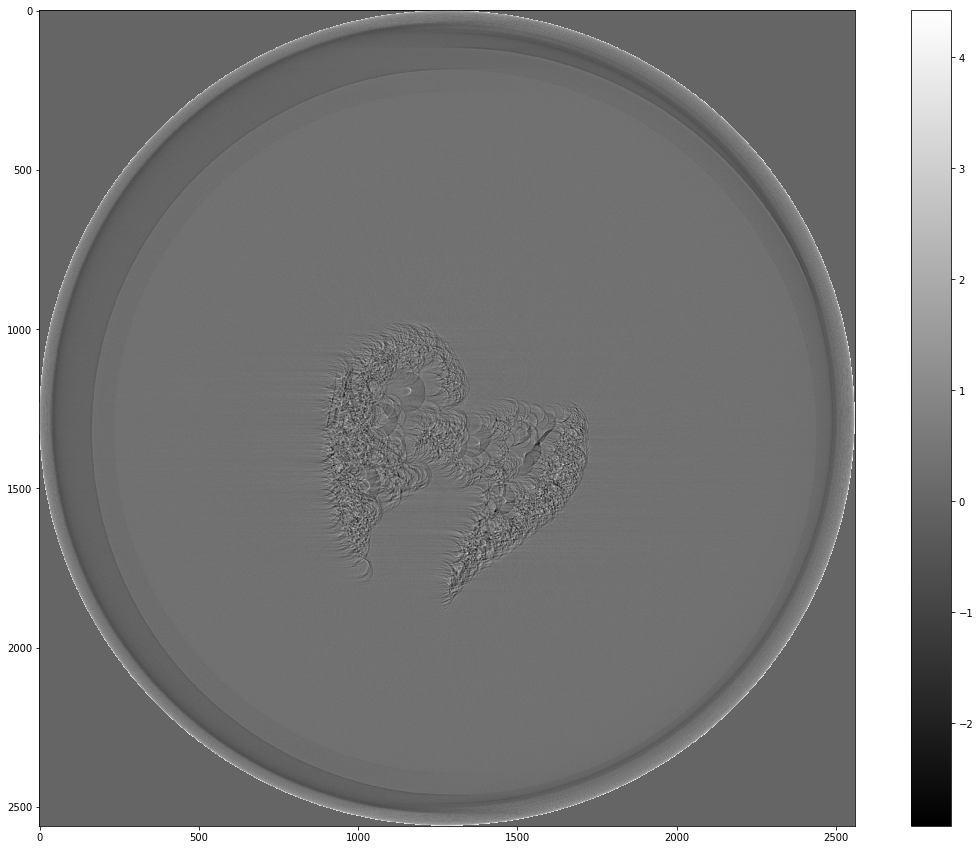

In [14]:
# Display the middle reconstructed slice
with h5py.File(xtract_output_ctworkflow_h5, 'r') as f:
    dset = f['exchange/data_recon']
    fig, ax = plt.subplots(figsize=(20, 15))
    fig.colorbar( ax.imshow(dset[dset.shape[0]/2] , cmap='gray'), ax=ax)  
    plt.show()